In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

In [3]:
# 学習データとテストデータ統合

all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
# 前データで欠損値の数を確認する

all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
# 欠損データを穴埋めする Fare

## PclassごとのFareの平均値を計算
Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
Fare_mean.columns = ["Pclass", "Fare_mean"]
Fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [6]:
## 欠損値を置き換える

all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")

all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
all_df = all_df.drop("Fare_mean", axis=1)

In [7]:
# Nameの欠損値を調べる

all_df["Name"].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [8]:
# 敬称を変数として追加する

name_df = all_df["Name"].str.split(pat="[,.]", n=2, expand=True)
name_df.columns = ["family_name", "honorific", "name"]

name_df

,family_name,honorific,name
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry
...,...,...,...
1304,Spector,Mr,Woolf
1305,Oliva y Ocana,Dona,Fermina
1306,Saether,Mr,Simon Sivertsen
1307,Ware,Mr,Frederick


In [9]:
# 先頭と末尾の空白文字の削除

name_df["family_name"] = name_df["family_name"].str.strip()
name_df["honorific"] = name_df["honorific"].str.strip()
name_df["name"] = name_df["name"].str.strip()

In [10]:
# 敬称ごとに人数をカウント

name_df["honorific"].value_counts()

honorific
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [11]:
# 敬称ごとの年齢分布を確認する

## ２つのDataFrameを結合
all_df = pd.concat([all_df, name_df],axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick


<Axes: xlabel='honorific', ylabel='Age'>

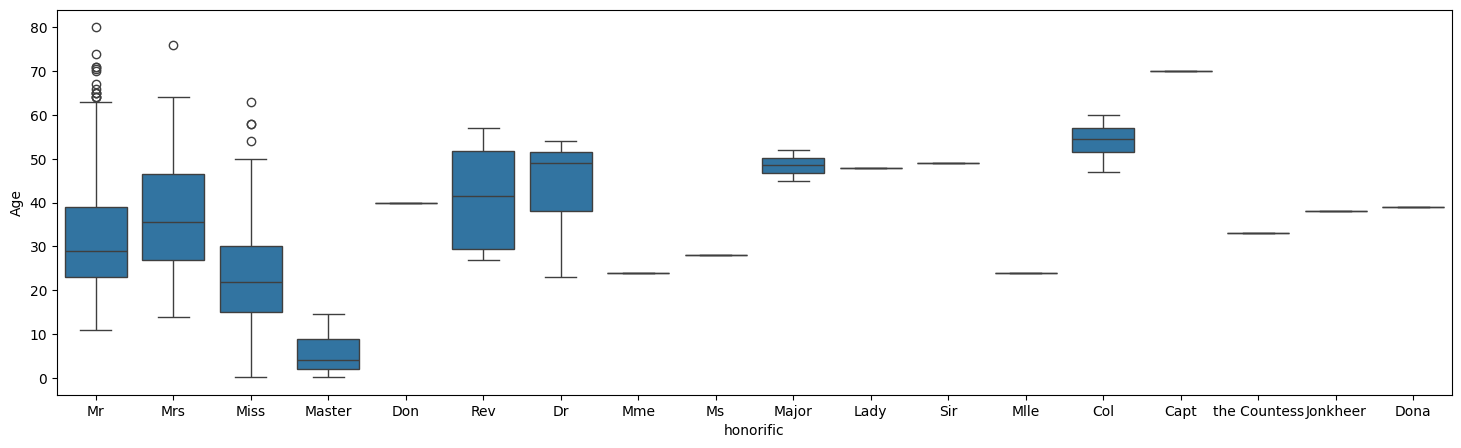

In [12]:
# 分布の確認

plt.figure(figsize=(18, 5))
sns.boxplot(x="honorific", y="Age", data=all_df)

In [13]:
# 敬称ごとの年齢の平均値

all_df[["Age", "honorific"]].groupby("honorific").mean()

,Age
honorific,
Capt,70.000000
Col,54.000000
Don,40.000000
Dona,39.000000
Dr,43.571429
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,5.482642


In [14]:
# 敬称ごとの生存率の違いについて確認する

train_df = pd.concat([train_df, name_df[0:len(train_df)].reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df, name_df[len(train_df):].reset_index(drop=True)], axis=1)

<Axes: xlabel='honorific'>

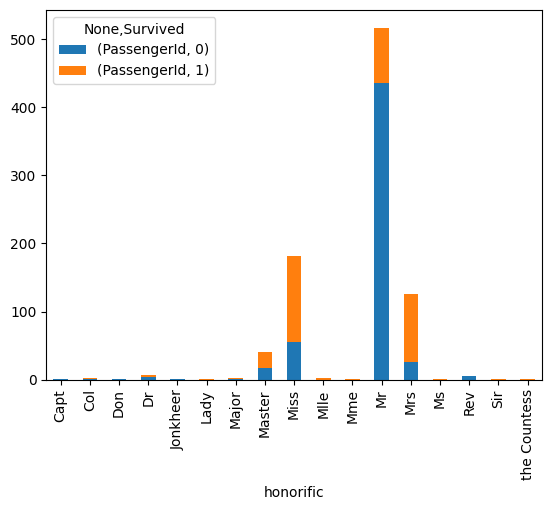

In [15]:
# 敬称ごとにSurvivedの値ごとの人数を集計

honorific_df = train_df[['honorific', "Survived", "PassengerId"]].dropna().groupby(["honorific", "Survived"]).count().unstack()
honorific_df.plot.bar(stacked=True)

In [16]:
# 敬称ごとの平均年齢で年齢が欠損しているデータを穴埋めする

honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").mean().reset_index()
honorific_age_mean.columns = ["honorific", "honorific_Age"]

all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
all_df = all_df.drop(["honorific_Age"],axis=1)

In [17]:
# 家族人数を追加する

all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
all_df["family_num"].value_counts()

family_num
0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: count, dtype: int64

In [18]:
# 家族人数が0かどうかを表す変数を追加

all_df.loc[all_df["family_num"] ==0, "alone"] = 1
all_df["alone"].fillna(0, inplace=True)

/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_28031/1790038299.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)


In [19]:
# 不要な変数を削除する
target_columns = ["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"]

if all(col in all_df.columns for col in target_columns):
    all_df = all_df.drop(columns=["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

all_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,1,0.0
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1,0.0
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0,1.0
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1,0.0
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,0,1.0


In [20]:
# カテゴリ変数を数値に変換する

categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


In [21]:
all_df.loc[~(
    (all_df["honorific"] == "Mr") |
    (all_df["honorific"] == "Miss") |
    (all_df["honorific"] == "Mrs") |
    (all_df["honorific"] == "Master")),
"honorific"] = "other"

all_df.honorific.value_counts()

honorific
Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: count, dtype: int64

In [22]:
all_df["Embarked"].fillna("missing", inplace=True)
all_df

/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_28031/852379214.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["Embarked"].fillna("missing", inplace=True)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,male,22.000000,1,0,7.2500,S,Mr,1,0.0
1,1.0,1,female,38.000000,1,0,71.2833,C,Mrs,1,0.0
2,1.0,3,female,26.000000,0,0,7.9250,S,Miss,0,1.0
3,1.0,1,female,35.000000,1,0,53.1000,S,Mrs,1,0.0
4,0.0,3,male,35.000000,0,0,8.0500,S,Mr,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,32.252151,0,0,8.0500,S,Mr,0,1.0
1305,NaN,1,female,39.000000,0,0,108.9000,C,other,0,1.0
1306,NaN,3,male,38.500000,0,0,7.2500,S,Mr,0,1.0
1307,NaN,3,male,32.252151,0,0,8.0500,S,Mr,0,1.0


In [23]:
# Label Encoding

le = LabelEncoder()
le = le.fit(all_df["Sex"])
all_df["Sex"] = le.transform(all_df["Sex"])

In [24]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtypes == "object":
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])

Sex
Embarked
honorific


In [25]:
all_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,1,22.0,1,0,7.2500,2,2,1,0.0
1,1.0,1,0,38.0,1,0,71.2833,0,3,1,0.0
2,1.0,3,0,26.0,0,0,7.9250,2,1,0,1.0
3,1.0,1,0,35.0,1,0,53.1000,2,3,1,0.0
4,0.0,3,1,35.0,0,0,8.0500,2,2,0,1.0


In [26]:
# 学習データとテストでーたに戻す

train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]

test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

In [27]:
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [28]:
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]

In [29]:
# 学習データの20％を検証データの分割する

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

In [30]:
# LightGBM用のデータセットを作成

categories = ["Embarked", "Pclass", "Sex", "honorific", "alone"]

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_train, y_train, categorical_feature=categories, reference=lgb_train)

In [31]:
# ハイパーパラメーターを設定する

lgbm_params = {
    "objective": "binary",
    "random_seed": 1234
}

In [32]:
# LightGBMによる機械学習モデルを学習させる

model_lgb = lgb.train(
    lgbm_params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(period=10)]
    )

[LightGBM] [Info] Number of positive: 279, number of negative: 433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391854 -> initscore=-0.439526
[LightGBM] [Info] Start training from score -0.439526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [33]:
# 各変数の重要度を調べる

model_lgb.feature_importance()

array([ 107,   58, 1051,   56,   44, 1095,  135,   36,   66,   18],
      dtype=int32)

<Axes: >

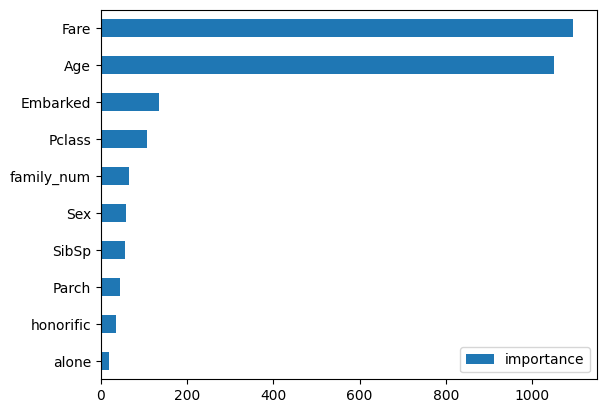

In [34]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=True)
importance.plot.barh()